# Домашнее задание №9
## Линейная регрессия
### PROC REG

_[Гончаренко Дмитрий Александрович, Жуков Павел Николаевич, Слабоузова Анна Константиновна]_

### 0. Подготовка файлов для выполнения ДЗ.
Вместе с этим файлом в архиве находится программа для создания набора данных _BodyFat_ для выполнения ДЗ: 
- FATDATAREG.sas;

Для вашего удобства в программе создаются макропеременные: с целевой переменной, предикторами и названием набора данных для анализа.


### Задание


### 1. Предварительное  исследование данных  
С помощью процедуры `proc corr` исследуйте корреляцию между целевой переменной и предикторами.
- в процедуре постройте графики типа scatter для визуального исследования характера зависимости (используя опции, постройте графики для **всех** предикторов);
- сохраните результаты работы процедуры - коэф. корреляции Пирсона и соответствующее p-value по всем предикторам - в набор данных (используйте операторы ods output ...; и ods trace ...;);
- исключите из анализа предикторы, для которых нельзя отклонить гипотезу о равенстве коэффициента корреляции нулю (уровень значимости 0.05), и предикторы, у которых корреляция < 0.3;
- с помощью процедуры proc sql (конструкция select ... into: separated by ' ') создайте макропеременную inputs, которая будет содержать список оставшихся переменных, разделенных пробелами. 

In [1]:
%include 'FATDATAREG.sas'

SAS Connection established. Subprocess id is 6512




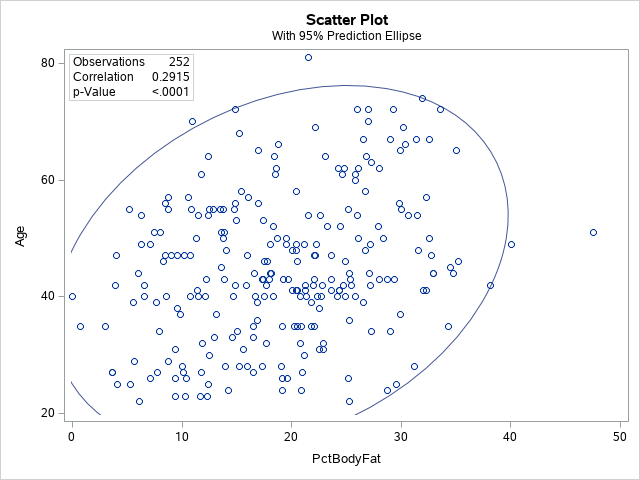
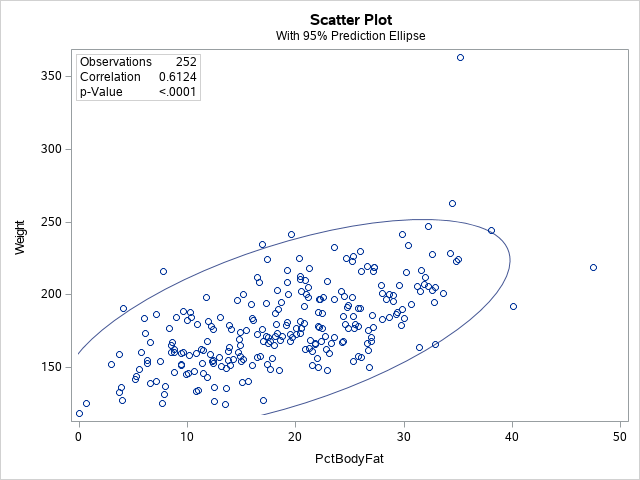
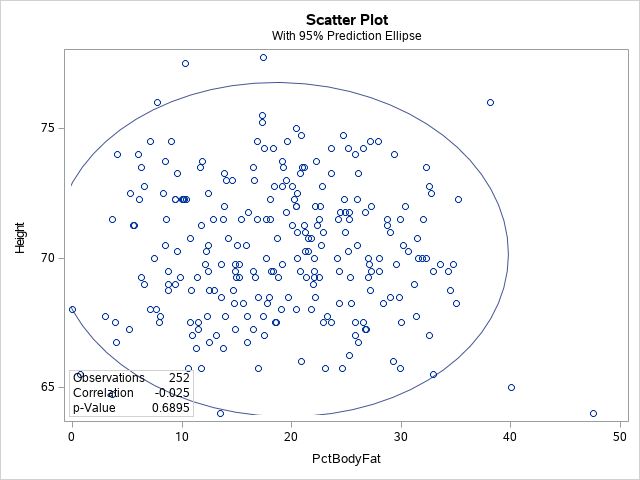
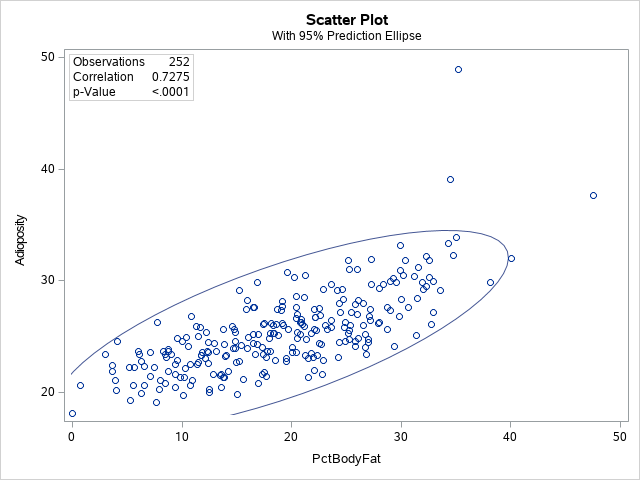
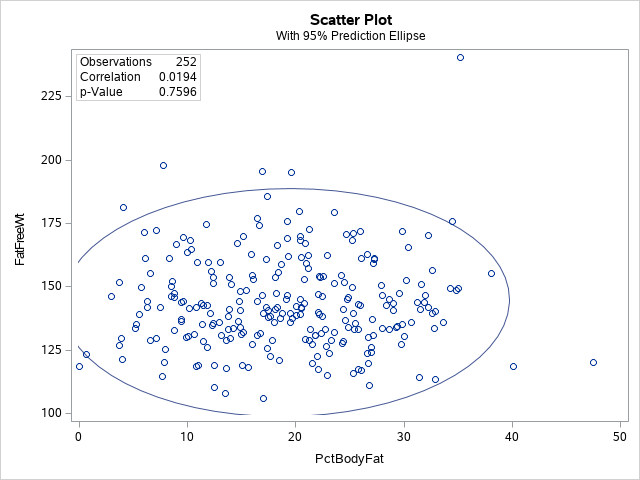

In [2]:
ods graphics on;
ods output PearsonCorr = result;
ods trace on;
proc corr data = work.BodyFat PEARSON
        /*
        Не получилось вывести все графики
        (NVAR=ALL requests that all variables in the VAR list be displayed with a maximum of 10)
        С помощью proc sgplot построить графики также не удалось.
        */
        plots=scatter(nvar=all);
    var PctBodyFat;
    with age weight height adioposity fatfreewt neck chest abdomen hip thigh knee ankle biceps forearm wrist;
run;
ods trace off;
ods graphics off;

In [3]:
data work.filtered;
    set work.result;
    if PPctBodyFat < 0.05 and PctBodyFat > 0.3 then output work.filtered;
run;

proc print data=work.filtered;
run;

Obs,Variable,PctBodyFat,PPctBodyFat
1,Weight,0.61241,<.0001
2,Adioposity,0.72748,<.0001
3,Neck,0.49059,<.0001
4,Chest,0.70262,<.0001
5,Abdomen,0.81343,<.0001
6,Hip,0.62520,<.0001
7,Thigh,0.55961,<.0001
8,Knee,0.50867,<.0001
9,Biceps,0.49327,<.0001
10,Forearm,0.36139,<.0001


In [4]:
proc sql noprint;
select Variable into: inputs separated by ' ' from work.filtered;
run;
%put &inputs;

#### Q1.1: Укажите переменные:
- 3 переменные с максимальной корреляцией: (1) Abdomen ;(2) Adioposity ;(3) Chest ;
- укажите переменные, для которых коэф. корреляции не отличается значимо от нуля: (1) FatFreeWt ; (2) Height ;

#### Q1.2: Можно ли утверждать, что для 3-х переменных с максимальной корреляцией связь c целевой  действительно линейная? 
Не можем, т.к. мы просто отвергаем гипотезу нулевой корреляции между ними, но этого недостаточно, чтобы утверждать о линейной связи с целевой переменной.

### 2. Выбор моделей кандидатов  
#### 2.1 Пошаговые методы 
Из оставшихся переменных, используя proc reg и метод forward, проведите отбор предикторов. Какой порог на p-value нужно выбрать, чтобы в модель вошло только 5 переменных? Используйте этот порог. Создайте макропеременную model1, содержащую список выбранных переменных, и используйте ее, чтобы построить регрессию на этих переменных (еще один запуск proc reg).

In [ ]:
/* Ваш код для выполнения задания (не забудьте запустить его) */

#### Q2.1.1: На сколько увеличился R-квадрат модели, когда 5-я переменная была добавлена? 
...
#### Q2.1.2 Какая переменная наиболее значимая в модели, какая  наименее? Почему вы так решили?
...

#### 2.2 Перебор подмножеств
Определите набор предикторов (не более 5), при использовании которых можно получить модель не хуже (в качестве метрики для выбора используйте RMSE), чем в п. 2.1. Создайте макропеременную model2, содержащую список выбранных переменных, и используйте ее, чтобы построить регрессию на этих переменных (еще один запуск proc reg).

In [ ]:
/* Ваш код для выполнения задания (не забудьте запустить его) */

#### Q2.2.1: Удалось ли построить модель лучше? 
...

### 3. Проверка предположений  
Выберете лучшую модель из двух, построенных ранее. Проверьте предположения регрессионного анализа для нее.

In [ ]:
/* Ваш код для выполнения задания (не забудьте запустить его) */

#### Q3.1: Укажите, какие предположения выполнены, а какие нет? Обязательно объясните, на основании чего Вы сделали такой вывод.
(1) ...;
(2) ...;
...
...
...


### 4. Поиск и исключение влиятельных наблюдений 
Используя статистику Cook's D, найдите два наиболее влятельных наблюдения в данных. Удалите их из набора.

In [ ]:
/* Ваш код для выполнения задания (не забудьте запустить его) */

#### Q4.1: Укажите номера найденных влиятельных наблюдений
(1) ...;
(2) ...;
#### Q4.2: Используя рекомендуемый порог для статитстики Cook's D - сколько наблюдений нужно было бы удалить?
...;

### 5. Исследование коллинеарности
Проведите исследование на наборе с удаленными влиятельными наблюдениями. Используйте опцию VIF, чтобы выявить наиболее проблемную переменную, и опцию collinoint, чтобы выявить с какими переменными найденная проблемная коррелирует.  

In [ ]:
/* Ваш код для выполнения задания (не забудьте запустить его) */ 

#### Q5.1: Укажите наиболее проблемную переменную, почему вы ее выбрали?
(1) ...;
#### Q5.2: С какими переменными она коррелирует? Почему? 
(1) ...;

**Подтвердите свои выводы запуском процедуры proc corr:**

In [ ]:
/* Ваш код для выполнения задания (не забудьте запустить его) */ 

#### Q5.3: Подтвердились ли выводы? Почему Вы так решили? 
...;
#### Q5.4 Удалите из модели проблемную и наиболее коррелирующую с ней? Как изменилась метрика RMSE?
...;

In [ ]:
/* Ваш код для выполнения задания (не забудьте запустить его) */ 